<a href="https://colab.research.google.com/github/earendil94/SMLExam/blob/master/SML_Project_Claudia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STATISTICAL MACHINE LEARNING**

ARRIGHI Leonardo, BRAND Francesco, DORIGO Claudia


Dataset folder is saved in "/content/drive/My Drive/SML/SML_Project".

In [7]:
# link colab and drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# then follow passages

Mounted at /content/drive


In [8]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import pandas as pd

import torchvision
from torchvision import transforms
from IPython import display

from PIL import Image
import glob

torch.manual_seed(160898)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [9]:
csv = '/content/drive/My Drive/SML/SML_Project/Chunk1/results.csv'
imgs = '/content/drive/My\ Drive/SML/SML_Project/Chunk1/img1_200/'

!ls {imgs} | wc

    200     200    2382


In [10]:
# Load csv
df = pd.read_csv(csv, delimiter='|') 
print(df.shape)
print(df.columns[2], df.columns[2] == ' comment') 
df[' comment'].values[0]
df.head(6)

(158915, 3)
 comment True


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...


10010052.jpg
tensor([[[-0.9192, -0.8849, -0.9192,  ..., -1.0733, -1.0904, -0.9705],
         [-1.0219, -1.0048, -0.9877,  ..., -1.1247, -1.1760, -1.0733],
         [-1.0048, -1.0048, -1.0219,  ..., -1.2617, -1.2445, -1.2617],
         ...,
         [-0.7137, -0.7479, -0.7822,  ...,  1.3070,  1.2557,  1.1700],
         [ 0.2624, -0.3369, -0.6623,  ...,  1.3584,  1.4612,  1.4098],
         [ 1.3413,  0.9132,  0.1768,  ...,  1.4269,  1.5468,  1.4954]],

        [[-0.5126, -0.5126, -0.5651,  ..., -0.8277, -0.8627, -0.7227],
         [-0.6352, -0.6877, -0.6352,  ..., -0.8277, -0.8803, -0.7752],
         [-0.6352, -0.6702, -0.6527,  ..., -0.9503, -0.9503, -0.9853],
         ...,
         [-0.3200, -0.3200, -0.3725,  ...,  1.4832,  1.4307,  1.3431],
         [ 0.5728,  0.0126, -0.2675,  ...,  1.5357,  1.6408,  1.5882],
         [ 1.5707,  1.1506,  0.5203,  ...,  1.6057,  1.7283,  1.6758]],

        [[-0.1138, -0.0964, -0.1661,  ..., -0.5844, -0.6018, -0.4624],
         [-0.2532, -0.2881, -0.2

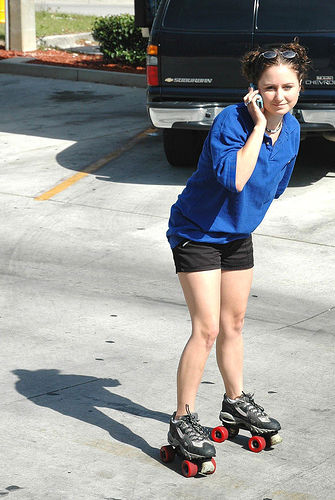

In [11]:
# Load images
# needed transformation: to tensor and normalize
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                              ])
images = [] #take the originals to print them
input_images = [] #transformed ones
names = [] #only way to connect images and comments
for filename in glob.glob("/content/drive/My Drive/SML/SML_Project/Chunk1/img1_200/*.jpg"):
    im=Image.open(filename)
    names.append(filename[56:])
    images.append(im)
    input_images.append(transform(im))
    
print(names[0])
print(input_images[0])
images[0]

In [14]:
# download the pretrained ResNet152 and look at the summary using torchsummary module
pretrained_ResNet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
#load model on gpu
if torch.cuda.is_available():
  pretrained_ResNet.to('cuda')

from torchsummary import summary
summary(pretrained_ResNet,(3,224,224))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
# model wants in input a 4-d tensor, first dimension number of inputs
# if single element use input_image = image.unsqueeze(0)
data = torch.stack(input_images,0)
print(data.shape)

#model is already on gpu, I need to move also data
if torch.cuda.is_available():
    data = data.to('cuda')
  
pretrained_ResNet.eval() # tells all layers to work in eval mode
with torch.no_grad(): # speed up computation and reduce memory usage 
    output = pretrained_ResNet(data)

# scores over 1000 classes
#print(output[0])
# from values to probabilities using softmax
class_probs = torch.nn.functional.softmax(output[0], dim=0)
#print(class_probs)
# probabilities so sum up to 1
print(sum(class_probs))


torch.Size([200, 3, 224, 224])
tensor(1.0000, device='cuda:0')


bow
trench_coat
tank
half_track
stretcher
projectile
bulletproof_vest
rifle
assault_rifle
military_uniform


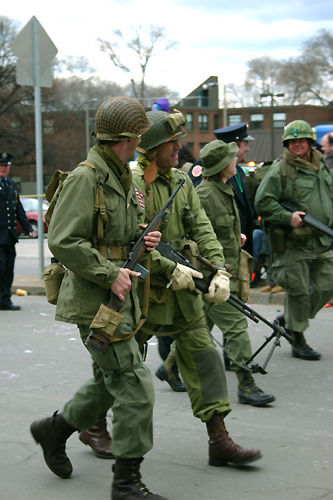

In [23]:
# check how classification works for one image
# no needed for our project but I can see if some features are well captured
import json
class_idx = json.load(open("/content/drive/My Drive/SML/SML_Project/classes.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

# sort wrt probability and take 10 more probable indexes
for idx in output[20].sort()[1][-10:]:
    print(idx2label[idx])

images[20]

In [26]:
# Now I should remove last layer of the ResNet
# to do that I replace it with identity
pretrained_ResNet.fc = nn.Identity()
summary(pretrained_ResNet,(3,224,224))

#I'm not sure if I have to remove other layers or if I have to add a new one...


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,